In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python

''' 
   watershedding-idealized-test.ipynb

   This program runs a test on MOAAP‘s watershedding algorithm with idealized "clouds"

'''

' \n   watershedding-idealized-test.ipynb\n\n   This program runs a test on MOAAP‘s watershedding algorithm with idealized "clouds"\n\n'

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
import matplotlib.path as mplPath
import sys
from calendar import monthrange
import warnings
warnings.filterwarnings("ignore")
from itertools import groupby
from tqdm import tqdm

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr
import netCDF4

#### Functions from "Tracking_Function.py" file
from Tracking_Functions import ObjectCharacteristics
from Tracking_Functions import interp_weights
from Tracking_Functions import interpolate
from Tracking_Functions import detect_local_minima
from Tracking_Functions import Feature_Calculation
from Tracking_Functions import haversine
from Tracking_Functions import BreakupObjects
from Tracking_Functions import ConnectLon
from Tracking_Functions import ReadERA5
from Tracking_Functions import ReadERA5_2D
from Tracking_Functions import minimum_bounding_rectangle 
from Tracking_Functions import is_land 
from Tracking_Functions import DistanceCoord 
from Tracking_Functions import moaap
from Tracking_Functions import calc_grid_distance_area
from Tracking_Functions import timer
#reload Tracking_Functions.watershed_2d_overlap
if 'watershed_2d_overlap' in dir():
    del watershed_2d_overlap

from Tracking_Functions import watershed_2d_overlap
from Tracking_Functions import watershed_3d_overlap

/tmp/ipykernel_57821/111956133.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
def reload_and_call_watershed_3d():
    import importlib
    import Tracking_Functions
    importlib.reload(Tracking_Functions)
    from Tracking_Functions import watershed_3d_overlap
    return watershed_3d_overlap

In [76]:
import numpy as np

# 1) Create lat/lon arrays at 0.1° spacing
n_lat, n_lon = 100, 100
lat_vals = np.arange(n_lat) * 0.1
lon_vals = np.arange(n_lon) * 0.1
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)

# 2) Initialize a 3D matrix (time, lat, lon) with background value 300
n_time = 24
data = np.full((n_time, n_lat, n_lon), 300.0)

# Circle parameters
radius = 2.0  # degrees
center1 = (5.0, 5.0)              # (lon, lat) fixed
initial_center2 = (7.0, 5.0)     # starting center for circle 2
final_separation = 5.0           # degrees, to remove overlap
# compute initial separation and per-step increment
dx0 = initial_center2[0] - center1[0]
dy0 = initial_center2[1] - center1[1]
initial_sep = np.hypot(dx0, dy0)
delta_sep = (final_separation - initial_sep) / (n_time - 1)

# Generate time series with two moving circles and evolving right-cell minimum
for t in range(n_time):
    # Compute center for circle 2 at this time step
    sep = initial_sep + delta_sep * t
    cx2 = center1[0] + sep  # pure longitude movement
    cy2 = center1[1]
    
    # Distance fields
    d1 = np.hypot(lon2d - center1[0], lat2d - center1[1])
    d2 = np.hypot(lon2d - cx2,       lat2d - cy2)
    
    # Left circle: fixed ramp from 240 at edge to 210 at center
    val1 = 210 + (240 - 210) * (d1 / radius)
    
    # Right circle: center value increases from 210 to 240 over first 10 steps
    if t < 10:
        center_val2 = 210 + (240 - 210) * (t / 9)
    else:
        center_val2 = 240.0
    # ramp from edge=240 down to evolving center_val2
    val2 = center_val2 + (240 - center_val2) * (d2 / radius)
    
    # Initialize slice with background
    slice_t = np.full((n_lat, n_lon), 300.0)
    
    # Apply circle 1
    mask1 = d1 <= radius
    slice_t[mask1] = val1[mask1]
    
    # Apply circle 2 (take the lower value where overlapping)
    mask2 = d2 <= radius
    slice_t[mask2] = np.minimum(slice_t[mask2], val2[mask2])
    
    # Save into the data cube
    data[t] = slice_t

# Quick check
print("data[0,50,50] (left circle center) =", data[0,50,50])
print("data[0,50,70] (right circle center) =", data[0,50,70])
print("data[9,50,70] (right center at t=9) =", data[9,50,70])
print("data[10,50,70] (right center at t=10) =", data[10,50,70])


data[0,50,50] (left circle center) = 210.0
data[0,50,70] (right circle center) = 210.0
data[9,50,70] (right center at t=9) = 240.0
data[10,50,70] (right center at t=10) = 240.0


100%|██████████| 23/23 [00:00<00:00, 3583.94it/s]


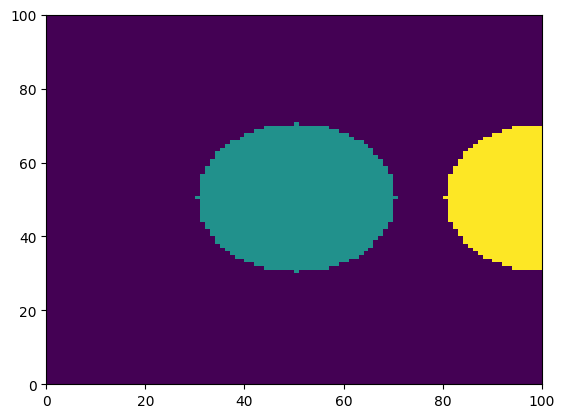

In [77]:
tb_threshold = 241 # K
dT = 1
C_objects = watershed_2d_overlap(
        data * -1,
        tb_threshold * -1,
        235 * -1, #tb_overshoot * -1, #CL_MaxT * -1,
        8,
        dT,
        mintime = 0,
        connectLon = 0, #connectLon,
        extend_size_ratio = 0.10
        )
# print((C_objects == 2).nonzero())
# plt.pcolormesh(C_objects[10,:,:])
plt.pcolormesh(C_objects[-1,:,:])

coords:  [[ 0 50 50]
 [ 0 50 70]
 [ 1 50 50]
 [ 1 50 71]
 [ 2 50 50]
 [ 2 50 73]
 [ 3 50 50]
 [ 3 50 74]
 [ 4 50 50]
 [ 4 50 75]
 [ 5 50 50]
 [ 5 50 77]
 [ 6 50 50]
 [ 6 50 78]
 [ 7 50 50]
 [ 7 50 79]
 [ 8 50 50]
 [ 9 50 50]
 [10 50 50]
 [11 50 50]
 [12 50 50]
 [13 50 50]
 [14 50 50]
 [15 50 50]
 [16 50 50]
 [17 50 50]
 [18 50 50]
 [19 50 50]
 [20 50 50]
 [21 50 50]
 [22 50 50]
 [23 50 50]]
-95


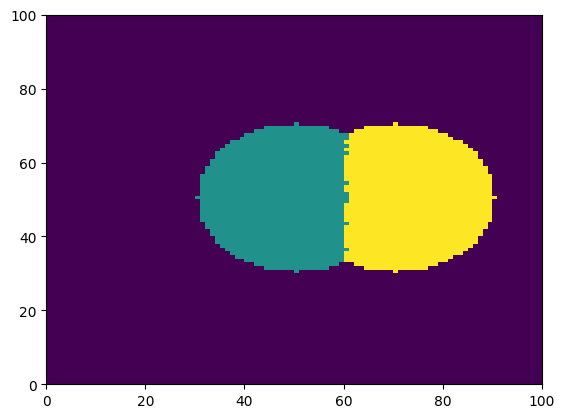

In [90]:
tb_threshold = 241 # K
dT = 1
watershed_3d = reload_and_call_watershed_3d()
C_objects_3d = watershed_3d(
        data * -1,
        tb_threshold * -1,
        235 * -1, #tb_overshoot * -1, #CL_MaxT * -1,
        8,
        dT,
        mintime = 0,
        connectLon = 0, #connectLon,
        extend_size_ratio = 0.10
        )
np.set_printoptions(threshold=np.inf)
# print the difference between the 2d and 3d method
print((C_objects - C_objects_3d).sum())
# print((C_objects_3d == 2).nonzero())
plt.clf()
# print(C_objects_3d[8,50,:])
plt.pcolormesh(C_objects_3d[0,:,:])

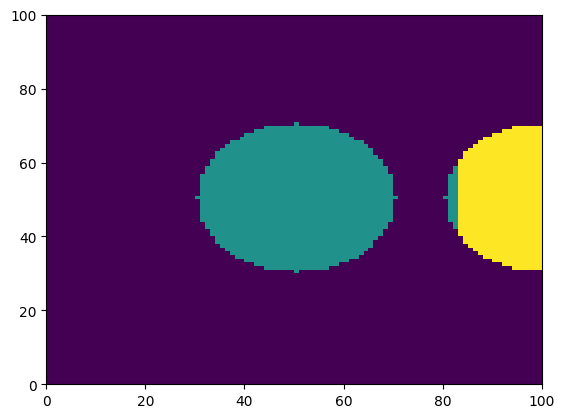

In [91]:
plt.pcolormesh(C_objects_3d[-1,:,:])

In [72]:
import numpy as np

# Parameters
n_time, n_lat, n_lon = 48, 200, 200
n_cells = 30         # number of synthetic cells
speed = 3.0          # 3× faster movement

# Initialize background field
data = np.full((n_time, n_lat, n_lon), 300.0)

# Precompute grid for distance calculations
yy, xx = np.ogrid[:n_lat, :n_lon]

# Cell value parameters
boundary_val = 240.0
center_val = 215.0

# Generate random moving cells
for _ in range(n_cells):
    # Double max lifespan: up to 36 timesteps
    duration = np.random.randint(6, 37)
    start = np.random.randint(0, n_time - duration + 1)
    
    # Random max area up to 1000 grid cells → compute max radius
    max_area = np.random.uniform(200, 1500)
    max_radius = np.sqrt(max_area / np.pi)
    
    # Only ensure initial cell fits: use radius margin only
    margin = int(np.ceil(max_radius))
    i0 = np.random.randint(margin, n_lat - margin)
    j0 = np.random.randint(margin, n_lon - margin)
    
    # Random direction, scaled by speed
    angle = np.random.uniform(0, 2 * np.pi)
    vy = speed * np.sin(angle)
    vx = speed * np.cos(angle)
    
    half = duration / 2
    for dt in range(duration):
        t = start + dt
        
        # Compute moving center
        cy = i0 + vy * dt
        cx = j0 + vx * dt
        
        # Growth then decay of radius
        if dt < half:
            r = 1 + (max_radius - 1) * (dt / half)
        else:
            r = max_radius - (max_radius - 1) * ((dt - half) / half)
        
        # Distance field
        dist = np.sqrt((yy - cy)**2 + (xx - cx)**2)
        mask = dist <= r
        
        # Linear ramp: boundary_val at r → center_val at dist=0
        vals = center_val + (boundary_val - center_val) * (dist / r)
        
        # Overlay, taking minimum to handle overlaps
        slice_t = data[t]
        slice_t[mask] = np.minimum(slice_t[mask], vals[mask])
        data[t] = slice_t

# Quick shape check
print("Generated data shape:", data.shape)


Generated data shape: (48, 200, 200)


In [73]:
C_objects = watershed_2d_overlap(
        data * -1,
        241 * -1,
        -235, #tb_overshoot * -1, #CL_MaxT * -1,
        2,
        dT,
        mintime = 0,
        connectLon = 0, #connectLon,
        extend_size_ratio = 0.10
        )

100%|██████████| 47/47 [00:00<00:00, 1078.52it/s]


In [74]:
watershed_3d = reload_and_call_watershed_3d()
C_objects_3d = watershed_3d(
        data * -1,
        241 * -1,
        -235, #tb_overshoot * -1, #CL_MaxT * -1,
        5,
        dT,
        mintime = 0,
        connectLon = 0, #connectLon,
        extend_size_ratio = 0.10
        )

labels:  [ 1  2  1  3  4  1  3  2  5  6  1  3  4  2  1  2  3  4  5  6  7  8  1  2
  4  3  6  5  4  1  3  2  5  6  8  7  9 10  1  6  4  2  3  5  7  8 11 12
 13  2  4  1  7  9  3  6 10  8  5 14 15  4  6  2  1  3  8  9  5 10  7 13
 12 11 16 17  8  3 13  4 12  6 14  1  2  7  5 11  9 15 10 18  3  2  4  6
  1  7 13 12  8 14  5 11  9 10 15 16 17  2  4  6  3 13 12  1  5  8 14 11
 17 10  9 16 15 18  7 19  6  5  2  3 12 11 13  4  8 10 14 18 16  1 17  9
 15  7 20  3  6  5 10 12  2 13  8 18 14  4 11 17  9 15 16 19  8  3 10  2
 12  6 11  5  4 15 17  9 14 18 20 13 16 19 21  5  3  6  2 10 17 12 18  9
 11 15 16 14  8 20 19  5  3 10  9 12  6 11  2 16 17 18 14 21 20 19  8 22
 17  9  3  6 11 10 12  2  5 18 20 16 19 14 21  8 23  9  2 16 12  3  5  6
 21 17 11 20 10 18 14 19 22 21  9 16  6 12  3 17 11 20  2  5 10 18 14 24
 19 22 23  9 17 21 10 18  3 20 12 11 14 16  5 24  2  6 23 22 19 10 16 17
 11  9  6 14 21 18  3 12  5 22 23  2 20 19 24 10 21 18 17 16 14 11 22  5
  9 12  3  2 23 19  6 20 23 21 10 17 14 18

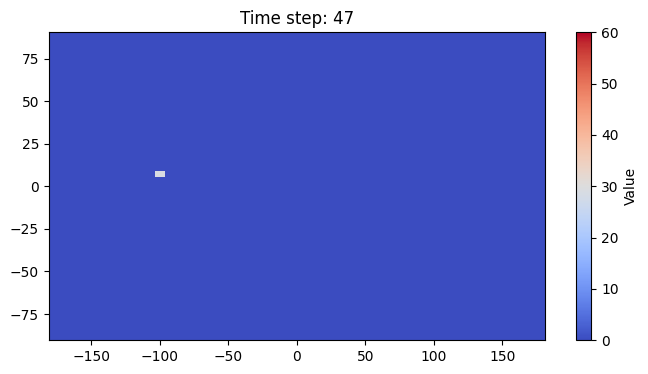

In [75]:
plt.close('all')

# Prepare your data
data, lat, lon = prepare_data(C_objects_3d)
time_steps = data.shape[0]

# Create meshgrid for plotting
Lon, Lat = np.meshgrid(lon, lat)

# --- Plot and animate ---
fig, ax = plt.subplots(figsize=(8, 4))
cmap = plt.get_cmap('coolwarm')

# Initial frame
pcm = ax.pcolormesh(Lon, Lat, data[0], cmap=cmap, vmin = 0, vmax = 60)
cbar = fig.colorbar(pcm, ax=ax, label='Value')
title = ax.set_title(f'Time step: 0')


# Create animation
anim = animation.FuncAnimation(
    fig,
    update,
    frames=time_steps,
    interval=200,    # ms between frames; adjust as desired
    blit=True
)

# Display in Jupyter as HTML5 video
# HTML(anim.to_html5_video())
HTML(anim.to_jshtml())


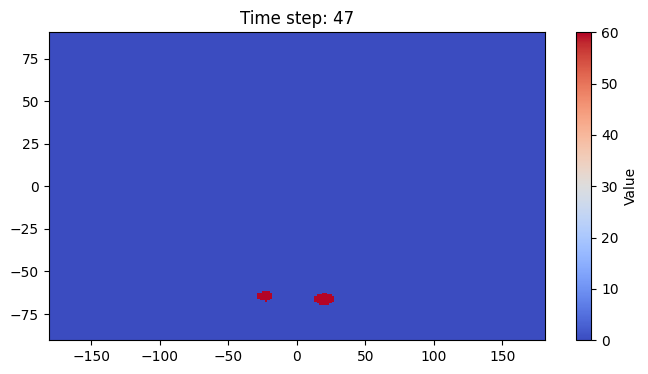

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# --- Data setup ---
# Assume `C_objects` is your 3D data array with shape (time, lat, lon).
# It can be a NumPy array or an xarray DataArray.

def prepare_data(C_objects):
    """
    Extracts the numpy data and lat/lon axes from C_objects.
    If C_objects is an xarray DataArray, it reads coordinate values.
    Otherwise, it falls back to index-based ranges.
    """
    if hasattr(C_objects, 'values') and hasattr(C_objects, 'coords'):
        data = C_objects.values
        # Adjust these names if your DataArray uses different coord names:
        lat = C_objects.coords.get('lat', C_objects.coords.get('latitude')).values
        lon = C_objects.coords.get('lon', C_objects.coords.get('longitude')).values
    else:
        # Fallback: assume plain numpy array of shape (time, nlat, nlon)
        data = np.array(C_objects)
        nlat, nlon = data.shape[1], data.shape[2]
        lat = np.linspace(-90, 90, nlat)
        lon = np.linspace(-180, 180, nlon)
    return data, lat, lon

# Prepare your data
data, lat, lon = prepare_data(C_objects)
time_steps = data.shape[0]

# Create meshgrid for plotting
Lon, Lat = np.meshgrid(lon, lat)

# --- Plot and animate ---
fig, ax = plt.subplots(figsize=(8, 4))
cmap = plt.get_cmap('coolwarm')

# Initial frame
pcm = ax.pcolormesh(Lon, Lat, data[0], cmap=cmap, vmin = 0, vmax = 60)
cbar = fig.colorbar(pcm, ax=ax, label='Value')
title = ax.set_title(f'Time step: 0')

# Update function for animation
def update(frame):
    pcm.set_array(data[frame].ravel())
    title.set_text(f'Time step: {frame}')
    return pcm, title

# Create animation
anim = animation.FuncAnimation(
    fig,
    update,
    frames=time_steps,
    interval=200,    # ms between frames; adjust as desired
    blit=True
)

# Display in Jupyter as HTML5 video
# HTML(anim.to_html5_video())
HTML(anim.to_jshtml())


In [45]:
n_time, n_lat, n_lon = data.shape

# 1) Create coordinate arrays
times = pd.date_range("2000-01-01", periods=n_time, freq="H")
lat   = np.arange(n_lat) * 0.1
lon   = np.arange(n_lon) * 0.1

# 2) Build an xarray Dataset with two data variables
ds = xr.Dataset(
    {
        "cell_field": (("time", "lat", "lon"), data),
        "other_field": (("time", "lat", "lon"), C_objects)
    },
    coords={
        "time": times,
        "lat":  lat,
        "lon":  lon
    }
)

# 3) (Optional) Add metadata
ds.other_field.attrs["long_name"] = "Another synthetic field"
ds.other_field.attrs["units"]     = "unitless"

# 4) Write to NetCDF
ds.to_netcdf("outputs/synthetic_cells.nc")